# **Boruta Shap Feature Analysis**
**what I want to learn:**
- **which features (taxonomic families) are important to blooms at day 3?**

**k fold cross validation documentation:**
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

**Needed libraries**

In [21]:
import pandas as pd
import numpy as np
import random as rnd
from os.path import join as pj
import shap
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor)

**Functions**

In [30]:
## generate x and y dataframes for machine learning and/or boruta shap/kfold cross validation
def make_xy_tables(meta_df,
                   otu_df,
                   merge_on,
                   y_col):
    output_dict = {}
    
    mini_meta = meta_df.loc[:, (merge_on, y_col)]
    comb_df = otu_df.merge(mini_meta, how="left", on=[merge_on])
    ## x - the side that has the data I want the model to use to predict y
    pre_x_df = comb_df.copy()
    x_df = pre_x_df.drop(y_col, axis=1)
    x_df[merge_on] = x_df[merge_on].astype(float)
    x_df = x_df.drop(merge_on, axis=1)
    ## y - what is to be predicted
    y_df = comb_df[y_col]

    ## saving my outputs
    output_dict.update({"x_dataframe": x_df,
                        "y_dataframe": y_df})
    return(output_dict)

## extracting shap plots outside of the big for loop to try and prevent my funky problem
def give_shap_plot(values):
   shap.plots.beeswarm(values, show=False)
   plt.title("Summary SHAP Plot")
   fig = plt.gcf()
   return(fig)


## run kfold cross validation on x and y datasets and then identify important features via boruta shap
def kfold_boruta_shap(k_fold,
                      feature_selector,
                      x_dataframe,
                      y_dataframe,
                      ##shap_class,
                      ##out_fp,
                      trial_num,
                      run_name):
    output_dict = {}

    train_list = []
    for i, (train_index, test_index) in enumerate(k_fold.split(x_dataframe, y_dataframe)):
        print(f"Fold {i}:")
        print(f"Training dataset index: {train_index}")
        print(f"Testing dataset index: {test_index}")
        ## setting up test/train datasets 
        x_train = x_dataframe.filter(items=train_index, axis=0)
        x_test = x_dataframe.filter(items=test_index, axis=0)
        y_train = y_dataframe.filter(items=train_index, axis=0)
        y_test = y_dataframe.filter(items=test_index, axis=0)

        ## running boruta shap on training data
        feature_selector.fit(X=x_train,
                             y=y_train, 
                             n_trials=trial_num,
                             random_state=0,
                             sample=False,
                             verbose=True)
        
        train_acc_features = feature_selector.accepted
        train_list = train_list + train_acc_features

        ## shap plot
        ##shap_plot_fp = pj(out_fp, f"fold{i}_shap_plot.pdf")
        ##shap_class.fit(x_train,
                       ##y_train)
        ##explainer = shap.Explainer(shap_class.predict,
                                   ##x_test)
        ##shap_values = explainer(x_test)
        ##shap_plot = give_shap_plot(shap_values,
                                   ##i)
        ##shap_plot.savefig(shap_plot_fp, dpi=150, format='pdf', bbox_inches='tight')
        ## since it's in a for loop i need to clear the previous matplotlib plot so the don't all get smushed together
        ##shap_plot.clf()

    ## saving my outputs
    output_dict.update({f"{run_name}_train": train_list})
    return(output_dict)


## to make the output table of the kfold cross validated boruta shap results
def create_occurence_table(input_list):
    wanted_df = pd.DataFrame(np.unique(input_list, return_counts=True)).T
    wanted_df.columns = ["feature", "num_occurences"]
    wanted_df = wanted_df.sort_values(by="num_occurences", ascending=False)
    wanted_df["av_occurences"] = wanted_df["num_occurences"]/5
    return(wanted_df) 

**File paths**

In [3]:
family_deltas_fp = "../data/family_deltas_wide.tsv"
meta_fp = "../data/ml_approved_metadata.tsv"
meta_keys_fp = "../data/meta_dict_keys.tsv"

## common variables for functions
bs_cols = ['family', 'num_occurences']
bs_sort_by = 'num_occurences'

## cross validator and boruta shap 
kf = KFold(n_splits=5)
rf_class = RandomForestClassifier()
rf_regress = RandomForestRegressor()
grad_boost = GradientBoostingClassifier(n_estimators=100)
random_forest_bs = BorutaShap(importance_measure='shap', 
                           classification=False)
grad_boost_bs = BorutaShap(model=grad_boost,
                        importance_measure='shap',
                        classification=True)
borutaShap_dict = {"random_forest": random_forest_bs}

**Reading in files and data wrangling**

In [4]:
family_deltas_df = pd.read_csv(family_deltas_fp, sep='\t')
meta = pd.read_csv(meta_fp, sep='\t')
meta_keys = pd.read_csv(meta_keys_fp, sep='\t')

In [5]:
## pulling out mouse id assigned numbers as a dictionary to map it to the deltas table
mouse_id_dict = dict(zip(meta_keys.mouse_id, meta_keys.assigned_num))
inverse_mouseID_dict = dict(zip(meta_keys.assigned_num, meta_keys.mouse_id))

In [6]:
## converting mouse ids in the deltas table to the same numbers as the metadata
##family_deltas_df["mouse_id"] = family_deltas_df["mouse_id"].map(mouse_id_dict)

## Bloom Status

In [6]:
## more data wrangling bc why not i love it!!! (that's sarcasm)
## im actually just generating my x and y dataframes 
bloom_xy = make_xy_tables(meta_df=meta,
                          otu_df=family_deltas_df,
                          merge_on="mouse_id",
                          y_col="bloom_status")

bloom_x_df = bloom_xy["x_dataframe"]
bloom_y_df = bloom_xy["y_dataframe"]

In [23]:
## need to shuffle the order of the columns in the x dataframe since they're in alphabetical order and that might bias shap
num_cols = list(range(0, len(bloom_x_df.columns)))
rnd.shuffle(num_cols)
print(num_cols)

[12, 40, 14, 8, 4, 25, 50, 51, 5, 35, 32, 21, 10, 3, 38, 7, 36, 23, 33, 37, 2, 18, 41, 43, 26, 15, 24, 29, 42, 1, 11, 39, 20, 49, 22, 44, 27, 30, 46, 45, 16, 28, 48, 17, 13, 34, 31, 47, 0, 9, 19, 6]


In [25]:
shuff_bloom_x_df = bloom_x_df.iloc[:,num_cols]
shuff_bloom_x_df

,f__Christensenellaceae,f__Ruminococcaceae,f__Clostridia_vadinBB60_group,f__Bacteroidaceae,f__Anaerofustaceae,f__Lachnospiraceae,f__[Eubacterium]_coprostanoligenes_group,f__uncultured,f__Anaerovoracaceae,f__Peptococcaceae,...,f__Weeksellaceae,f__Desulfovibrionaceae,f__Clostridia_UCG-014,f__Oscillospirales,f__Morganellaceae,f__UCG-010,f__AKAU3644,f__Beggiatoaceae,f__Enterobacteriaceae,f__Atopobiaceae
0,0.000000,-0.014230,-0.002459,-0.000080,0.00000,-0.115194,-0.022600,0.00000,-0.002030,0.000000,...,0.00000,0.000000,-0.037801,0.00000,0.293888,-0.000560,0.000000,0.000000,0.000000,0.000000
1,-0.002480,-0.007091,-0.004781,-0.056910,0.00000,-0.334627,-0.000320,-0.00013,-0.001870,-0.004131,...,0.00000,-0.002390,-0.034806,0.00000,0.135769,-0.000560,0.000000,0.000000,0.033090,0.000000
2,0.000000,-0.004768,-0.004010,0.002038,0.00000,-0.178595,-0.020661,0.00000,0.002724,-0.000180,...,0.00000,0.000000,-0.029512,0.00000,0.212880,-0.000880,0.000000,0.000000,0.002038,0.000121
3,-0.000630,-0.019218,-0.009560,0.534085,-0.00023,-0.646835,-0.001520,0.00000,-0.002970,-0.000880,...,0.00000,-0.004171,-0.016492,0.00000,0.000000,0.000000,0.000000,0.000000,-0.000520,0.000000
4,-0.001630,-0.014650,-0.015450,-0.027750,-0.00010,-0.386990,-0.000130,0.00000,-0.003380,-0.003050,...,0.00000,-0.003670,-0.031280,0.00000,0.000000,0.000000,0.000000,0.000000,0.657387,0.000000
5,-0.000530,-0.010020,-0.008970,0.550971,0.00000,-0.273263,-0.000530,0.00000,-0.001210,-0.000220,...,0.00000,-0.001730,-0.002650,0.00000,0.000000,0.000000,0.000000,0.000000,0.227976,0.000000
6,0.000000,-0.006431,-0.002383,0.000730,0.00000,-0.225606,-0.010361,0.00000,0.005780,0.000000,...,0.00000,0.000000,-0.022505,0.00000,0.097602,-0.000811,0.000000,0.000000,0.000000,0.000000
7,0.000000,-0.006820,-0.001080,0.000140,0.00000,-0.191106,-0.005470,0.00000,-0.001320,0.000000,...,0.00000,0.000000,-0.036381,0.00000,0.164787,-0.000230,0.000000,0.000000,0.000000,0.000000
8,0.000000,-0.013713,-0.008772,0.000000,0.00000,-0.198048,-0.008872,0.00000,-0.003491,0.000000,...,0.00000,0.000000,-0.030507,0.00000,0.248542,0.000000,0.000000,0.000000,-0.000200,0.000000
9,0.000000,-0.012020,-0.004740,0.000000,0.00000,-0.181048,-0.015020,0.00000,-0.002200,-0.000170,...,0.00000,0.000000,-0.029920,0.00000,0.107379,-0.000780,0.000000,0.000000,0.047563,0.000000


In [26]:
bloom_bs_acc_train = {}
for label, boruta_shap in borutaShap_dict.items():
    bloom_results = kfold_boruta_shap(k_fold=kf,
                                      feature_selector=boruta_shap,
                                      x_dataframe=shuff_bloom_x_df,
                                      y_dataframe=bloom_y_df,
                                      trial_num=100,
                                      ##shap_class=rf_class,
                                      ##out_fp="../outputs/deltas_bloomStatus_ml/",
                                      run_name="bloom")
    
    ## pulling out boruta shap accepted features 
    ## training data
    bloom_train_list = bloom_results["bloom_train"]
    bs_bloom_train_df = create_occurence_table(input_list=bloom_train_list)
    bs_bloom_train_df["bs_model"] = label

    bloom_bs_acc_train.update({f"{label}_accepted": bs_bloom_train_df})


bloom_train_features = pd.concat(bloom_bs_acc_train, ignore_index=True)

Fold 0:
Training dataset index: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46]
Testing dataset index: [0 1 2 3 4 5 6 7 8 9]


  0%|          | 0/100 [00:00<?, ?it/s]

5 attributes confirmed important: [' f__UCG-010', ' f__Enterococcaceae', ' f__Erysipelotrichaceae', ' f__Akkermansiaceae', ' f__Peptostreptococcaceae']
46 attributes confirmed unimportant: [' f__Alicyclobacillaceae', ' f__Deferribacteraceae', ' f__Acholeplasmataceae', ' f__Peptococcaceae', ' f__Erysipelatoclostridiaceae', ' f__Hungateiclostridiaceae', ' f__Oscillospirales', ' f__Tannerellaceae', ' f__AKAU3644', ' f__Enterobacteriaceae', ' f__Butyricicoccaceae', ' f__Oscillospiraceae', ' f__Desulfovibrionaceae', ' f__Sutterellaceae', ' f__Rikenellaceae', ' f__Marinifilaceae', ' f__Moorellaceae', ' f__Bacteroidaceae', ' f__Clostridia_vadinBB60_group', ' f__Xanthomonadaceae', ' f__Clostridiaceae', ' f__[Eubacterium]_coprostanoligenes_group', ' f__Streptococcaceae', ' f__Moraxellaceae', ' f__Lactobacillaceae', ' f__Beggiatoaceae', ' f__Saccharimonadaceae', ' f__Ruminococcaceae', ' f__Morganellaceae', ' f__Gastranaerophilales', ' f__Anaerofustaceae', ' f__Christensenellaceae', ' f__Monoglob

  0%|          | 0/100 [00:00<?, ?it/s]

5 attributes confirmed important: [' f__Deferribacteraceae', ' f__Enterococcaceae', ' f__Erysipelotrichaceae', ' f__Akkermansiaceae', ' f__Peptostreptococcaceae']
46 attributes confirmed unimportant: [' f__Alicyclobacillaceae', ' f__Acholeplasmataceae', ' f__Peptococcaceae', ' f__Erysipelatoclostridiaceae', ' f__Hungateiclostridiaceae', ' f__Oscillospirales', ' f__Tannerellaceae', ' f__AKAU3644', ' f__UCG-010', ' f__Butyricicoccaceae', ' f__Oscillospiraceae', ' f__Desulfovibrionaceae', ' f__Sutterellaceae', ' f__Rikenellaceae', ' f__Bacteroidaceae', ' f__Moorellaceae', ' f__Marinifilaceae', ' f__Clostridia_vadinBB60_group', ' f__Xanthomonadaceae', ' f__Clostridiaceae', ' f__RF39', ' f__[Eubacterium]_coprostanoligenes_group', ' f__Streptococcaceae', ' f__Moraxellaceae', ' f__Lactobacillaceae', ' f__Beggiatoaceae', ' f__Saccharimonadaceae', ' f__Ruminococcaceae', ' f__Morganellaceae', ' f__Gastranaerophilales', ' f__Anaerofustaceae', ' f__Christensenellaceae', ' f__Monoglobaceae', ' f__A

  0%|          | 0/100 [00:00<?, ?it/s]

8 attributes confirmed important: [' f__Enterococcaceae', ' f__Enterobacteriaceae', ' f__Desulfovibrionaceae', ' f__Peptococcaceae', ' f__Erysipelotrichaceae', ' f__Akkermansiaceae', ' f__Peptostreptococcaceae', ' f__[Eubacterium]_coprostanoligenes_group']
43 attributes confirmed unimportant: [' f__Alicyclobacillaceae', ' f__Deferribacteraceae', ' f__Acholeplasmataceae', ' f__Erysipelatoclostridiaceae', ' f__Hungateiclostridiaceae', ' f__Oscillospirales', ' f__AKAU3644', ' f__UCG-010', ' f__Butyricicoccaceae', ' f__Oscillospiraceae', ' f__Sutterellaceae', ' f__Rikenellaceae', ' f__Bacteroidaceae', ' f__Moorellaceae', ' f__Marinifilaceae', ' f__Clostridia_vadinBB60_group', ' f__Xanthomonadaceae', ' f__Clostridiaceae', ' f__RF39', ' f__Streptococcaceae', ' f__Moraxellaceae', ' f__Lactobacillaceae', ' f__Beggiatoaceae', ' f__Saccharimonadaceae', ' f__Ruminococcaceae', ' f__Morganellaceae', ' f__Gastranaerophilales', ' f__Anaerofustaceae', ' f__Christensenellaceae', ' f__Monoglobaceae', ' 

  0%|          | 0/100 [00:00<?, ?it/s]

5 attributes confirmed important: [' f__Enterococcaceae', ' f__Erysipelotrichaceae', ' f__Akkermansiaceae', ' f__Peptostreptococcaceae', ' f__[Eubacterium]_coprostanoligenes_group']
46 attributes confirmed unimportant: [' f__Alicyclobacillaceae', ' f__Deferribacteraceae', ' f__Acholeplasmataceae', ' f__Peptococcaceae', ' f__Erysipelatoclostridiaceae', ' f__Hungateiclostridiaceae', ' f__Oscillospirales', ' f__Tannerellaceae', ' f__AKAU3644', ' f__UCG-010', ' f__Enterobacteriaceae', ' f__Butyricicoccaceae', ' f__Oscillospiraceae', ' f__Desulfovibrionaceae', ' f__Sutterellaceae', ' f__Rikenellaceae', ' f__Marinifilaceae', ' f__Moorellaceae', ' f__Bacteroidaceae', ' f__Clostridia_vadinBB60_group', ' f__Xanthomonadaceae', ' f__Clostridiaceae', ' f__Streptococcaceae', ' f__Moraxellaceae', ' f__Lactobacillaceae', ' f__Beggiatoaceae', ' f__Saccharimonadaceae', ' f__Ruminococcaceae', ' f__Morganellaceae', ' f__Gastranaerophilales', ' f__Anaerofustaceae', ' f__Christensenellaceae', ' f__Monoglob

  0%|          | 0/100 [00:00<?, ?it/s]

4 attributes confirmed important: [' f__Enterococcaceae', ' f__Akkermansiaceae', ' f__[Eubacterium]_coprostanoligenes_group', ' f__Erysipelotrichaceae']
44 attributes confirmed unimportant: [' f__Alicyclobacillaceae', ' f__Deferribacteraceae', ' f__Acholeplasmataceae', ' f__Peptococcaceae', ' f__Erysipelatoclostridiaceae', ' f__Hungateiclostridiaceae', ' f__Oscillospirales', ' f__AKAU3644', ' f__UCG-010', ' f__Enterobacteriaceae', ' f__Butyricicoccaceae', ' f__Oscillospiraceae', ' f__Sutterellaceae', ' f__Marinifilaceae', ' f__Bacteroidaceae', ' f__Moorellaceae', ' f__Rikenellaceae', ' f__Clostridia_vadinBB60_group', ' f__Xanthomonadaceae', ' f__Clostridiaceae', ' f__Streptococcaceae', ' f__Moraxellaceae', ' f__Lactobacillaceae', ' f__Beggiatoaceae', ' f__Saccharimonadaceae', ' f__Ruminococcaceae', ' f__Morganellaceae', ' f__Gastranaerophilales', ' f__Anaerofustaceae', ' f__Christensenellaceae', ' f__Monoglobaceae', ' f__Anaerovoracaceae', ' f__Eggerthellaceae', ' f__Sphingomonadaceae'

<Figure size 800x550 with 0 Axes>

- f_RF39: unclassified enterococcaceae bacterium
- f_UCG-010: i have no idea, after looking it up on the silva database website (the database I used to classify the taxonomy for this data in qiime), they're not sure where to place it (insertae sedis) but there's a bunch of uncultured clostridiales/clostridiaceae bacterium under it (I wouldn't be too dependent on that though bc there's 973 unclassified bacterium that are under UCG-010)

In [ ]:
bloom_train_features

In [27]:
shap_x_train,shap_x_test,shap_y_train,shap_y_test = train_test_split(shuff_bloom_x_df,
                                                 bloom_y_df,
                                                 test_size=0.2,
                                                 random_state=42)

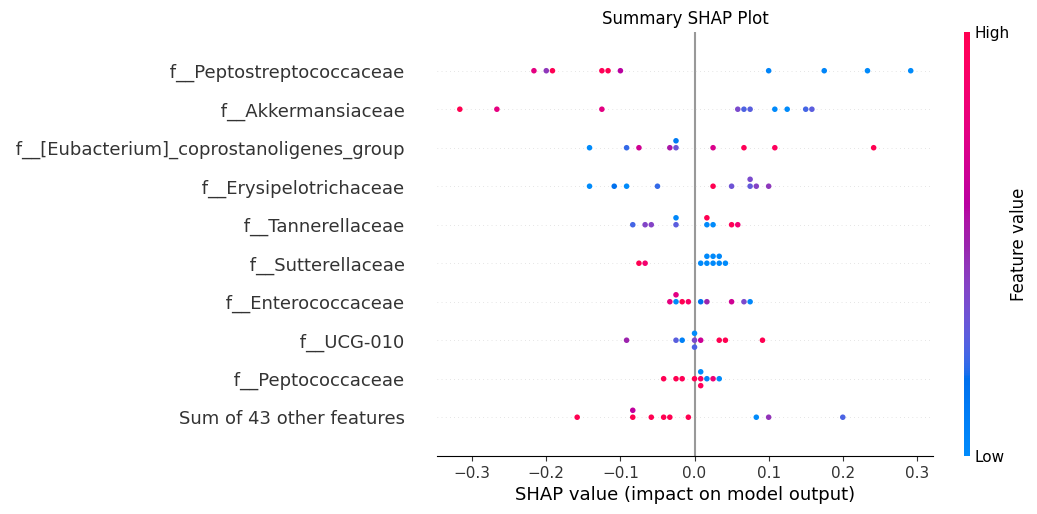

In [31]:
rf_class.fit(shap_x_train,
            shap_y_train)
explainer = shap.Explainer(rf_class.predict,
                           shap_x_test)
shap_values = explainer(shap_x_test)
shap_plot = give_shap_plot(shap_values)

**Saving my outputs**

In [16]:
## bloom status
shap_plot.savefig("../outputs/deltas_bloomStatus_ml/shap_plot.pdf", dpi=150, format='pdf', bbox_inches='tight')
bloom_train_features.to_csv("../data/outputs/borutaShap_bloom_train.tsv", sep="\t")